In [16]:
import pandas as pd
import numpy as np
from openai import OpenAI
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import os
from dotenv import load_dotenv

import plotly.graph_objects as go
import plotly.express as px

In [2]:

load_dotenv()

client = OpenAI()

In [19]:
def get_embedding(text, model="text-embedding-3-small"):
    """Get embedding for a given text using OpenAI API"""
    try:
        text = text.replace("\n", " ")
        response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

def create_embeddings_dataframe(df):
    """Create embeddings for each row in the dataframe"""
    print("Creating embeddings for Q&A pairs...")
    
    embeddings_list = []
    texts_list = []
    
    # Iterate through dataframe rows
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        # Combine question and answer for better semantic representation
        combined_text = f"Tópico: {row['Tópico']} | Programa: {row['Programa']} | Pergunta: {row['Pergunta']} " #| Resposta: {row['Resposta']}
        texts_list.append(combined_text)
        
        # Get embedding
        embedding = get_embedding(combined_text)
        
        if embedding is not None:
            embeddings_list.append(embedding)
        else:
            # If API call fails, add zeros (you might want to handle this differently)
            print(f"Failed to get embedding for row {index}")
            embeddings_list.append([0] * 1536)  # text-embedding-3-small has 1536 dimensions
    
    # Create embeddings dataframe
    embeddings_df = pd.DataFrame(embeddings_list)
    
    # Add metadata columns
    embeddings_df['original_index'] = df.index
    embeddings_df['topico'] = df['Tópico'].values
    embeddings_df['programa'] = df['Programa'].values
    embeddings_df['pergunta'] = df['Pergunta'].values
    embeddings_df['resposta'] = df['Resposta'].values
    embeddings_df['combined_text'] = texts_list
    
    return embeddings_df

def apply_tsne(embeddings_df):
    """Apply t-SNE dimensionality reduction"""
    print("Applying t-SNE dimensionality reduction...")
    
    # Extract only the embedding columns (exclude metadata)
    embedding_cols = [col for col in embeddings_df.columns if isinstance(col, int)]
    embeddings_matrix = embeddings_df[embedding_cols].values
    
    # t-SNE for 3D
    print("Reducing to 3D...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
    embeddings_3d = tsne_3d.fit_transform(embeddings_matrix)
    
    # t-SNE for 2D
    print("Reducing to 2D...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne_2d.fit_transform(embeddings_matrix)
    
    return embeddings_3d, embeddings_2d

# def create_3d_plot(embeddings_3d, embeddings_df):
#     """Create 3D visualization"""
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Color by topic
#     topics = embeddings_df['topico'].unique()
#     colors = plt.cm.Set3(np.linspace(0, 1, len(topics)))
#     topic_color_map = dict(zip(topics, colors))
    
#     for topic in topics:
#         mask = embeddings_df['topico'] == topic
#         ax.scatter(
#             embeddings_3d[mask, 0], 
#             embeddings_3d[mask, 1], 
#             embeddings_3d[mask, 2],
#             c=[topic_color_map[topic]], 
#             label=topic, 
#             alpha=0.7,
#             s=50
#         )
    
#     ax.set_xlabel('t-SNE 1')
#     ax.set_ylabel('t-SNE 2')
#     ax.set_zlabel('t-SNE 3')
#     ax.set_title('3D t-SNE Visualization of Q&A Embeddings')
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
#     plt.tight_layout()
#     plt.savefig('qa_embeddings_3d.png', dpi=300, bbox_inches='tight')
#     plt.show()

def create_3d_plot(embeddings_3d, embeddings_df):
    """Create interactive 3D visualization using Plotly"""
    
    # Get unique topics and assign colors
    topics = embeddings_df['topico'].unique()
    colors = px.colors.qualitative.Set3[:len(topics)]
    
    # Create the figure
    fig = go.Figure()
    
    # Add trace for each topic
    for i, topic in enumerate(topics):
        mask = embeddings_df['topico'] == topic
        topic_data = embeddings_df[mask]
        topic_coords = embeddings_3d[mask]
        
        # Create hover text with pergunta
        hover_text = [f"Tópico: {topic}<br>Programa: {programa}<br>Pergunta: {pergunta}" 
                     for programa, pergunta in zip(topic_data['programa'], topic_data['pergunta'])]
        
        fig.add_trace(go.Scatter3d(
            x=topic_coords[:, 0],
            y=topic_coords[:, 1],
            z=topic_coords[:, 2],
            mode='markers',
            marker=dict(
                size=6,
                color=colors[i % len(colors)],
                opacity=0.7
            ),
            name=topic,
            text=hover_text,
            hovertemplate='%{text}<extra></extra>'
        ))
    
    # Update layout
    fig.update_layout(
        title="3D t-SNE Visualization of Q&A Embeddings",
        scene=dict(
            xaxis_title="t-SNE 1",
            yaxis_title="t-SNE 2",
            zaxis_title="t-SNE 3",
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1024,
        height=768,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    fig.show()


def create_2d_plot(embeddings_2d, embeddings_df):
    """Create 2D visualization"""
    plt.figure(figsize=(12, 8))
    
    # Color by topic
    topics = embeddings_df['topico'].unique()
    
    for i, topic in enumerate(topics):
        mask = embeddings_df['topico'] == topic
        plt.scatter(
            embeddings_2d[mask, 0], 
            embeddings_2d[mask, 1],
            label=topic, 
            alpha=0.7,
            s=50
        )
    
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('2D t-SNE Visualization of Q&A Embeddings')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('qa_embeddings_2d.png', dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
df = pd.read_excel("Base de Conhecimento - Jornada do Estudante 2025-08-14.xlsx")
df.shape

(246, 4)

In [5]:
df

,Tópico,Programa,Pergunta,Resposta
0,Educação Básica,Programa Pé-de-Meia,A escola precisa realizar alguma ação no Progr...,A escola precisa garantir o envio dos dados do...
1,Educação Básica,Programa Pé-de-Meia,A Rede poderá corrigir os dados enviados a cad...,"Sim, a cada mês haverá um período para eventua..."
2,Educação Básica,Programa Pé-de-Meia,"Atendo às condicionalidades, mas não quero ser...",O estudante que não quer ser beneficiário do P...
3,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO EJAParce...
4,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO REGULARP...
...,...,...,...,...
241,Formação técnica,Institutos Federais,Onde encontro cursos técnicos gratuitos perto ...,Os Institutos Federais e outras escolas técnic...
242,Formação técnica,Institutos Federais,Posso fazer um curso técnico sem ter feito o E...,Cada escola técnica ou Instituto Federal tem s...
243,Formação técnica,Institutos Federais,Quanto tempo dura um curso técnico?,A maioria dos cursos técnicos pós-médio dura e...
244,Formação técnica,Institutos Federais,Que áreas de cursos técnicos posso fazer?,"Existem opções como informática, enfermagem, l..."


In [6]:
embeddings_df = create_embeddings_dataframe(df)

Creating embeddings for Q&A pairs...


Processing rows:   0%|          | 0/246 [00:00<?, ?it/s]

In [8]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,1532,1533,1534,1535,original_index,topico,programa,pergunta,resposta,combined_text
0,0.012805,0.032942,0.017282,0.027930,0.004832,0.029750,0.023541,0.052119,-0.005991,-0.018753,...,-0.007294,0.021471,0.018616,-0.007656,0,Educação Básica,Programa Pé-de-Meia,A escola precisa realizar alguma ação no Progr...,A escola precisa garantir o envio dos dados do...,Tópico: Educação Básica | Programa: Programa P...
1,0.019040,0.045539,0.019824,0.045231,0.007982,0.022508,-0.007471,0.054685,-0.026416,-0.011076,...,-0.001278,0.004543,0.013505,0.004766,1,Educação Básica,Programa Pé-de-Meia,A Rede poderá corrigir os dados enviados a cad...,"Sim, a cada mês haverá um período para eventua...",Tópico: Educação Básica | Programa: Programa P...
2,0.025132,0.019358,-0.014894,0.038818,-0.014499,0.027371,0.010410,0.058913,-0.008089,-0.032331,...,-0.007771,0.017641,0.002169,0.011485,2,Educação Básica,Programa Pé-de-Meia,"Atendo às condicionalidades, mas não quero ser...",O estudante que não quer ser beneficiário do P...,Tópico: Educação Básica | Programa: Programa P...
3,-0.005007,0.003180,0.011227,0.017593,-0.006887,0.041370,0.004474,0.029587,-0.023649,-0.037669,...,-0.005359,0.020826,0.006565,-0.031742,3,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO EJAParce...,Tópico: Educação Básica | Programa: Programa P...
4,0.006658,0.008195,0.012566,0.016074,-0.006512,0.041932,-0.000520,0.029660,-0.030716,-0.032124,...,-0.011908,0.021177,0.008019,-0.037849,4,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO REGULARP...,Tópico: Educação Básica | Programa: Programa P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.076146,0.021971,0.010280,0.016833,-0.012519,0.008293,0.019150,0.043818,-0.035808,-0.017358,...,-0.020025,-0.012437,-0.008427,0.039762,241,Formação técnica,Institutos Federais,Onde encontro cursos técnicos gratuitos perto ...,Os Institutos Federais e outras escolas técnic...,Tópico: Formação técnica | Programa: Instituto...
242,-0.037857,0.016454,-0.037413,-0.017533,0.021012,0.020726,0.003014,0.022587,-0.011410,0.022164,...,0.000810,-0.009411,0.004748,0.030201,242,Formação técnica,Institutos Federais,Posso fazer um curso técnico sem ter feito o E...,Cada escola técnica ou Instituto Federal tem s...,Tópico: Formação técnica | Programa: Instituto...
243,-0.071205,0.021515,-0.016263,-0.022649,-0.020220,0.041108,0.049305,0.000130,0.006775,0.028701,...,-0.015281,-0.000371,0.016101,0.051168,243,Formação técnica,Institutos Federais,Quanto tempo dura um curso técnico?,A maioria dos cursos técnicos pós-médio dura e...,Tópico: Formação técnica | Programa: Instituto...
244,-0.041606,0.011062,0.006131,-0.007361,-0.002134,0.014316,0.011550,0.041280,-0.017407,0.006817,...,-0.011632,-0.013116,0.019450,0.045673,244,Formação técnica,Institutos Federais,Que áreas de cursos técnicos posso fazer?,"Existem opções como informática, enfermagem, l...",Tópico: Formação técnica | Programa: Instituto...


In [9]:
print("Saving embeddings dataframe...")
embeddings_df.to_csv('qa_embeddings.csv', index=False)

Saving embeddings dataframe...


In [10]:
with open('qa_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_df, f)

In [11]:
print(f"Embeddings dataframe saved! Shape: {embeddings_df.shape}")

Embeddings dataframe saved! Shape: (246, 1542)


In [12]:
embeddings_3d, embeddings_2d = apply_tsne(https://mtegovbr.sharepoint.com/:x:/r/sites/CGIA77/Documentos%20Compartilhados/General/05.%20Promo%C3%A7%C3%A3o%20em%20Rede%20de%20IA/04.%20Experimenta%C3%A7%C3%B5es%20de%20IA/Chatbot%20Servi%C3%A7os%20GOV.BR/Base%20de%20Conhecimento%20-%20Consolida%C3%A7%C3%A3o.xlsx?d=w683735c553354cce9ea5468e694895b7&csf=1&web=1&e=5bIuKw)

Applying t-SNE dimensionality reduction...
Reducing to 3D...


/home/cmoryah/anaconda3/envs/chatbot/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Reducing to 2D...


/home/cmoryah/anaconda3/envs/chatbot/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [14]:
embeddings_3d[:20]

array([[ -4.020558 ,  14.088811 , -11.874476 ],
       [ -9.466651 , -30.917246 ,  -9.931134 ],
       [ 15.58817  ,  32.916412 , -20.995728 ],
       [ 25.219091 ,   2.6078668,  -6.3339596],
       [ 23.757915 ,   2.2764559, -11.458394 ],
       [  2.4266217,  19.836    , -36.45132  ],
       [  7.5876226,  18.99033  , -26.691065 ],
       [-11.012233 , -16.476336 , -17.814642 ],
       [  8.20212  , -35.168983 ,  -2.1371229],
       [ -8.477002 ,  -5.758851 ,  -1.0527217],
       [ 24.531544 , -17.258368 ,   1.2357774],
       [  5.102739 ,  -6.256683 ,   5.604626 ],
       [ 18.83104  , -17.623253 ,  11.484649 ],
       [ 28.385773 , -17.15695  , -24.836405 ],
       [  9.69565  , -31.774927 , -22.61401  ],
       [ 13.106539 , -27.750229 , -26.718472 ],
       [ 29.748516 , -12.331655 , -27.711477 ],
       [ -4.3909883, -15.51398  , -30.40179  ],
       [ -1.4981985, -20.69872  , -35.621788 ],
       [ -9.721706 ,  -7.5694995, -10.135995 ]], dtype=float32)

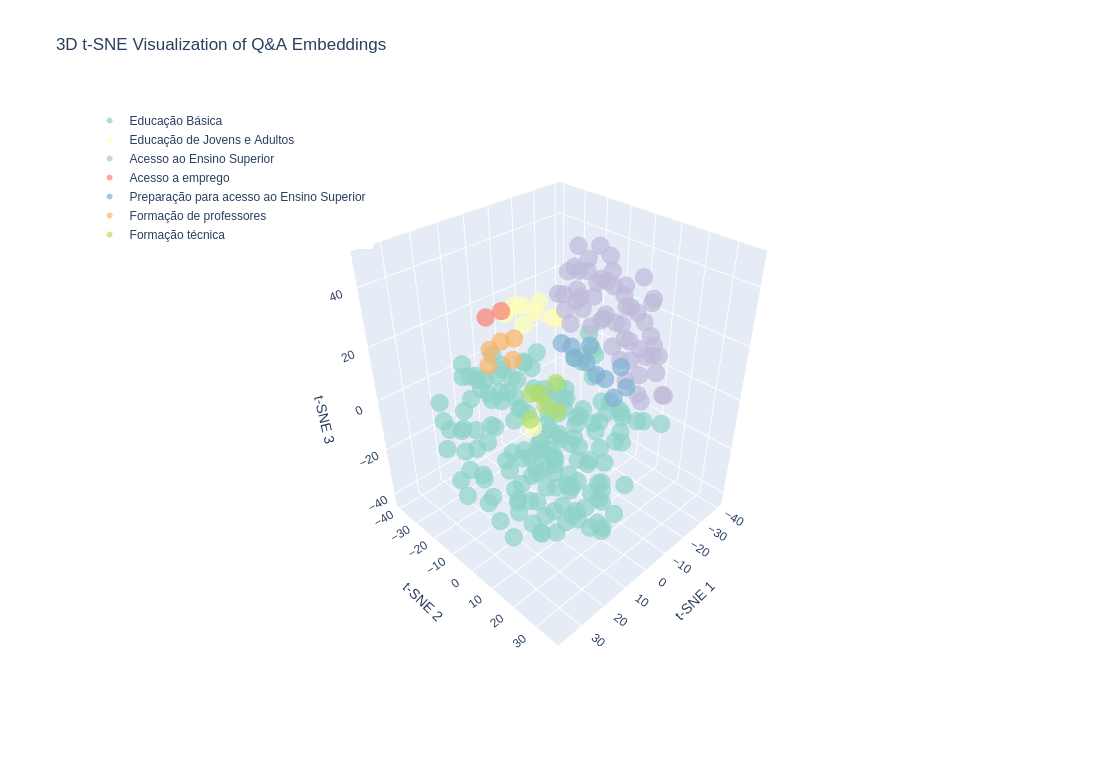

In [20]:
create_3d_plot(embeddings_3d, embeddings_df)


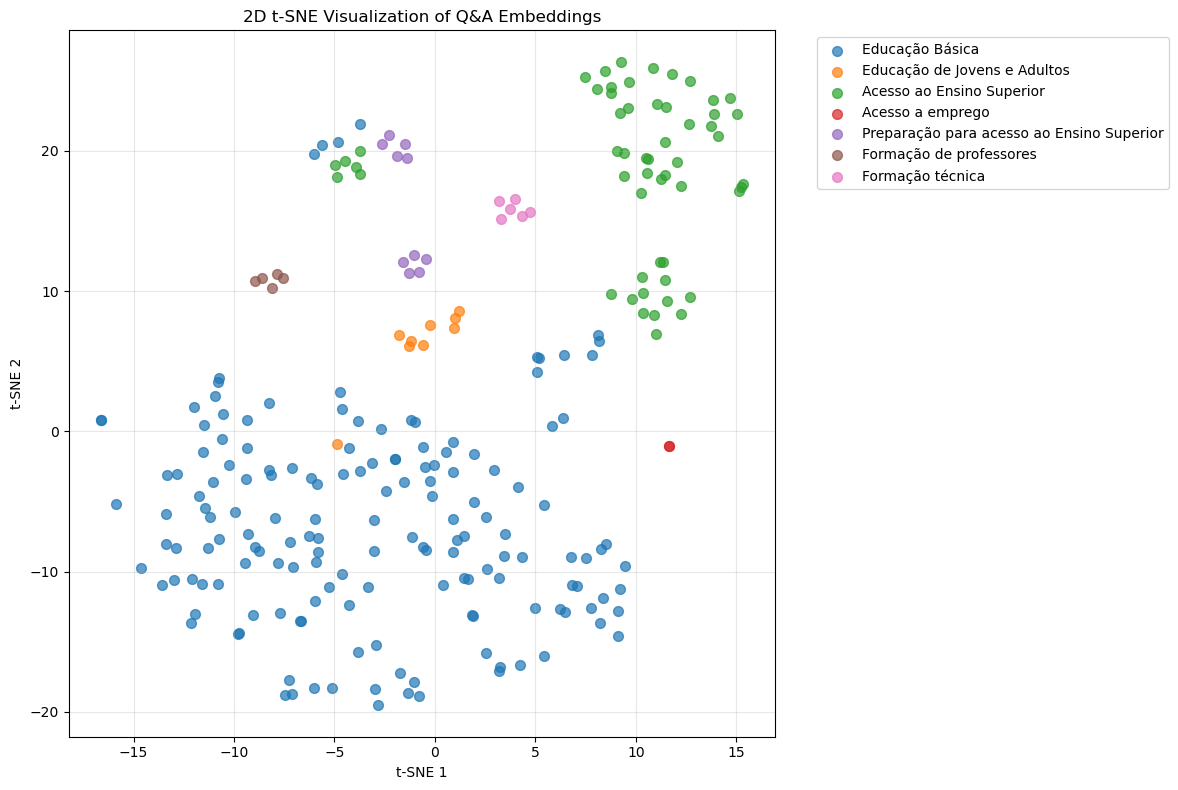

In [21]:
create_2d_plot(embeddings_2d, embeddings_df)

In [ ]:
246 rows × 1542 columns